# Настройка среды и импорт библиотек

In [2]:
!sudo apt-get update
!sudo apt-get install python3.8 python3.8-venv

!python3.8 -m venv py38_env
!source py38_env/bin/activate

!pip uninstall -y simplejson berserk
!pip install berserk==0.10.0 python-chess scipy numpy pandas tqdm

import sys
sys.executable = "/usr/bin/python3.8"

!sudo apt-get install stockfish
!pip install chess-engine


Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:8 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ Packages [73.0 kB]
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:12 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,693 kB]
Get:13 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [8,837 k

In [3]:
import berserk                                         # Библиотека для выгрузки шахматных партий
import chess.pgn                                       # Библиотека для преобразования шахматных партий в формат PGN
import pandas as pd
from scipy import stats                                # Модуль для статистической обработки данных
import numpy as np
from datetime import datetime, timedelta
import time
from tqdm import tqdm                                  # Функция, позволяющая отобразить прогресс-бар с числом и процентом проанализированных партий
import math
import matplotlib.pyplot as plt
import chess.engine                                    # Библиотека для работы с шахматным движком
from statsmodels.graphics.gofplots import qqplot       # Функция, позволяющая визуализировать распределение данных относительно нормального
from io import StringIO                                # Библиотека для прочтения PGN-файлов



# Задание функций

In [4]:
def get_player_games(username, days=365, perf_type="blitz", end_date=None, token='lip_XdtZYxfUqOjOV0zNOSck'):
    """
    Получает партии игрока за указанное количество месяцев

    Параметры:
        username (str): Ник игрока на Lichess
        days (int): Количество дней для выборки
        perf_type (str): Тип игры ('blitz', 'bullet', 'rapid' и т.д.)
        end_date (datetime): Конечная дата выборки (по умолчанию текущая дата)

    Возвращает:
        list: Список объектов chess.pgn.Game
    """

    # Объект, который управляет HTTP-сессией и добавляет ваш API-токен к каждому запросу.
    session = berserk.TokenSession(token)

    # Объект TokenSession, который будет использоваться для запросов.
    client = berserk.Client(session)

    if end_date is None:
        end_date = datetime.now()
    elif isinstance(end_date, str):
        try:
            end_date = datetime.strptime(end_date, '%Y-%m-%d')
        except ValueError as e:
            print(f"Неверный формат даты. Используйте 'YYYY-MM-DD'. Ошибка: {e}")
            end_date = datetime.now()

    start_date = end_date - timedelta(days=days)

    try:
        # Получаем генератор PGN-текстов
        pgn_generator = client.games.export_by_player(
            username,
            since=berserk.utils.to_millis(start_date),
            perf_type=perf_type,
            as_pgn=True
        )

        # Читаем PGN через StringIO
        games = []
        for pgn_text in pgn_generator:
            try:
                pgn_io = StringIO(pgn_text)
                game = chess.pgn.read_game(pgn_io)
                if game:
                    games.append(game)
            except Exception as e:
                print(f"Ошибка при разборе PGN: {e}")
                continue

        return games

    except Exception as e:
        print(f"Ошибка при получении партий: {e}")

In [5]:
!which stockfish || find / -name stockfish 2>/dev/null | head -5

/usr/games/stockfish
/usr/share/doc/stockfish


In [6]:
def analyze_games_with_engine(games, engine_path='/usr/games/stockfish', depth=20):
    """
    Анализирует партии с помощью шахматного движка и возвращает оценки позиций после каждого хода.

    Параметры:
        games (list): Список объектов chess.pgn.Game
        engine_path (str): Путь к исполняемому файлу шахматного движка (например, stockfish)
        depth (int): Глубина анализа движка (количество полуходов)

    Возвращает:
        list: Список списков с оценками для каждой партии
    """
    # Инициализируем движок
    engine = chess.engine.SimpleEngine.popen_uci(engine_path)

    all_games_scores = []

    for game in tqdm(games, desc="Анализ партий", unit="game"):
        try:
            board = game.board()
            game_scores = [0.3]  # Начальная оценка

            for move in game.mainline_moves():
                board.push(move)
                info = engine.analyse(board, chess.engine.Limit(depth=depth))
                score = info["score"].white().score(mate_score=10000)  # Увеличим mate_score для надежности

                if score is not None:
                    # Правильное масштабирование оценки (делим на 100, так как 1 пешка = 100 единиц)
                    normalized_score = score / 100
                    # Ограничиваем диапазон для избежания экстремальных значений
                    normalized_score = min(max(normalized_score, -10), 10)  # ±10 пешек
                else:
                    normalized_score = 0.0

                game_scores.append(normalized_score)

            all_games_scores.append(game_scores)

        except Exception as e:
            print(f"\nОшибка при анализе партии: {e}")
            all_games_scores.append([])
            continue

    engine.quit()
    return all_games_scores

In [7]:
def analyze_player_losses(all_games_scores):
    """
    Анализирует потери в сантипешках для всех партий.

    Параметры:
        all_games_scores (list): Список списков с оценками позиций для каждой партии

    Возвращает:
        list: Список списков с потерями в сантипешках для каждой партии
    """
    all_games_losses = []

    for game_scores in all_games_scores:
        if not game_scores:
            all_games_losses.append([])
            continue

        game_losses = []

        # Проходим по всем ходам (начиная с первого)
        for i in range(1, len(game_scores)):
            if i % 2 == 1:  # Ход белых (нечетный индекс)
                delta = game_scores[i] - game_scores[i-1]
                if delta < 0:  # Ухудшение позиции белых
                    loss = abs(delta) * 100
                else:  # Улучшение или без изменений
                    loss = 0
            else:  # Ход черных (четный индекс)
                delta = game_scores[i] - game_scores[i-1]
                if delta > 0:  # Ухудшение позиции черных (увеличение оценки в пользу белых)
                    loss = delta * 100
                else:  # Улучшение или без изменений
                    loss = 0

            game_losses.append(loss)

        all_games_losses.append(game_losses)

    return all_games_losses

In [8]:
def calculate_win_percent(centipawns):
    """Вычисляет Win% из сантипешек"""
    return 50 + 50 * (2 / (1 + math.exp(-0.00368208 * centipawns)) - 1)

def calculate_accuracy(win_diff):
    """Вычисляет Accuracy% из разницы Win%"""
    return 103.1668 * math.exp(-0.04354 * win_diff) - 3.1669

def analyze_player_performance(username, engine_path='/usr/games/stockfish', token='lip_XdtZYxfUqOjOV0zNOSck',  end_date=None, days=365, perf_type="blitz", depth=20):
    """
    Анализирует партии игрока и возвращает DataFrame с метриками

    Параметры:
        username (str): Ник игрока
        engine_path (str): Путь к движку
        days (int): За сколько дней партии
        perf_type (str): Тип игры
        depth (int): Глубина анализа

    Возвращает:
        pd.DataFrame: DataFrame с метриками по партиям
    """
    # 1. Загружаем партии
    games = get_player_games(username, days=days, perf_type=perf_type, token=token)

    # 2. Анализируем оценки позиций
    all_games_scores = analyze_games_with_engine(games, engine_path, depth=depth)

    # 3. Анализируем потери сантипешек
    all_games_losses = analyze_player_losses(all_games_scores)

    results = []

    for game, game_scores, game_losses in zip(games, all_games_scores, all_games_losses):
        if not game_scores or not game_losses:
            continue

        # Определяем цвет игрока
        player_is_white = (game.headers["White"] == username)
        opponent = game.headers["Black"] if player_is_white else game.headers["White"]

        # Инициализируем метрики для партии
        total_accuracy = 0
        total_moves = 0
        blunders = 0
        mistakes = 0
        inaccuracies = 0
        total_loss = 0

        # Проходим по всем ходам
        for i in range(len(game_losses)):
            if player_is_white:
                # Для белых анализируем нечетные ходы (1, 3, 5...)
                if i % 2 == 0:
                    # Конвертируем оценки в сантипешки
                    cp_before = game_scores[i] * 100
                    cp_after = game_scores[i+1] * 100

                    # Вычисляем Win%
                    win_before = calculate_win_percent(cp_before)
                    win_after = calculate_win_percent(cp_after)
                    win_diff = win_before - win_after

                    # Вычисляем Accuracy
                    accuracy = calculate_accuracy(abs(win_diff))
                    total_accuracy += accuracy
                    total_moves += 1

                    # Анализируем потери
                    loss = game_losses[i]
                    total_loss += loss

                    if loss > 300:
                        blunders += 1
                    elif loss > 100:
                        mistakes += 1
                    elif loss > 50:
                        inaccuracies += 1
            else:
                # Для черных анализируем четные ходы (2, 4, 6...)
                if i % 2 == 1:
                    # Конвертируем оценки в сантипешки
                    cp_before = game_scores[i] * 100
                    cp_after = game_scores[i+1] * 100

                    # Вычисляем Win%
                    win_before = calculate_win_percent(-cp_before)  # Инвертируем для черных
                    win_after = calculate_win_percent(-cp_after)
                    win_diff = win_before - win_after

                    # Вычисляем Accuracy
                    accuracy = calculate_accuracy(abs(win_diff))
                    total_accuracy += accuracy
                    total_moves += 1

                    # Анализируем потери
                    loss = game_losses[i]
                    total_loss += loss

                    if loss > 200:
                        blunders += 1
                    elif loss > 100:
                        mistakes += 1
                    elif loss > 50:
                        inaccuracies += 1

        # Вычисляем средние значения
        if total_moves > 0:
            avg_accuracy = total_accuracy / total_moves
            avg_loss = total_loss / total_moves
        else:
            avg_accuracy = 0
            avg_loss = 0

        # Добавляем результат партии
        results.append({
            "Opponent": opponent,
            "Color": "White" if player_is_white else "Black",
            "Accuracy": round(avg_accuracy, 1),
            "AvgLoss": round(avg_loss, 1),
            "Blunders": blunders,
            "Mistakes": mistakes,
            "Inaccuracies": inaccuracies,
            "TotalMoves": total_moves
        })

    # Создаем DataFrame
    df = pd.DataFrame(results)

    return df

In [9]:
def plot_all_metrics(players_stats):

    """
    Выводит гистограммы для всех метрик
    """

    fig, axes = plt.subplots(3, 2, figsize=(12, 12))
    fig.delaxes(axes[2, 1])  # Удаляем 6-й пустой подграфик

    # Цвета для каждого графика
    colors = ['skyblue', 'salmon', 'gold', 'lightgreen', 'violet']
    titles = ['Accuracy', 'AvgLoss', 'Blunders', 'Mistakes', 'Inaccuracies']
    xlabels = ['Точность (%)', 'Ср. потери (сантипешки)', 'Зевки', 'Ошибки', 'Неточности']

    # Гистограмма Accuracy
    axes[0, 0].hist(players_stats['Accuracy'], bins=30, color=colors[0], edgecolor='black')
    axes[0, 0].axvline(players_stats['Accuracy'].mean(), color='red', linestyle='--', linewidth=1)
    axes[0, 0].set_title(titles[0])
    axes[0, 0].set_xlabel(xlabels[0])
    axes[0, 0].grid(True, linestyle='--', alpha=0.6)

    # Гистограмма AvgLoss
    axes[0, 1].hist(players_stats['AvgLoss'], bins=30, color=colors[1], edgecolor='black')
    axes[0, 1].axvline(players_stats['AvgLoss'].mean(), color='red', linestyle='--', linewidth=1)
    axes[0, 1].set_title(titles[1])
    axes[0, 1].set_xlabel(xlabels[1])
    axes[0, 1].grid(True, linestyle='--', alpha=0.6)

    # Гистограмма Blunders
    axes[1, 0].hist(players_stats['Blunders'], bins=15, color=colors[2], edgecolor='black')
    axes[1, 0].axvline(players_stats['Blunders'].mean(), color='red', linestyle='--', linewidth=1)
    axes[1, 0].set_title(titles[2])
    axes[1, 0].set_xlabel(xlabels[2])
    axes[1, 0].grid(True, linestyle='--', alpha=0.6)

    # Гистограмма Mistakes
    axes[1, 1].hist(players_stats['Mistakes'], bins=15, color=colors[3], edgecolor='black')
    axes[1, 1].axvline(players_stats['Mistakes'].mean(), color='red', linestyle='--', linewidth=1)
    axes[1, 1].set_title(titles[3])
    axes[1, 1].set_xlabel(xlabels[3])
    axes[1, 1].grid(True, linestyle='--', alpha=0.6)

    # Гистограмма Inaccuracies
    axes[2, 0].hist(players_stats['Inaccuracies'], bins=15, color=colors[4], edgecolor='black')
    axes[2, 0].axvline(players_stats['Inaccuracies'].mean(), color='red', linestyle='--', linewidth=1)
    axes[2, 0].set_title(titles[4])
    axes[2, 0].set_xlabel(xlabels[4])
    axes[2, 0].grid(True, linestyle='--', alpha=0.6)

    plt.tight_layout()
    plt.show()

In [10]:
def normality_check(data):
    """
    Проверяет нормальность распределения данных:
    - строит гистограмму с линией среднего,
    - QQ-plot для проверки нормальности,
    - выводит ключевые статистики.
    """
    # Создаем фигуру с двумя subplots
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))

    # Гистограмма
    axes[0].hist(data, bins=30, density=True, edgecolor='black', alpha=0.7)
    axes[0].axvline(data.mean(), color='red', linestyle='--', linewidth=1, label=f'Среднее = {data.mean():.2f}')
    axes[0].set_title(f'Гистограмма ({data.name})')
    axes[0].legend()
    axes[0].grid(True, linestyle='--', alpha=0.6)

    # QQ-plot (используем statsmodels)
    qqplot(data, line='s', ax=axes[1])
    axes[1].set_title('QQ-plot для проверки нормальности')
    axes[1].grid(True, linestyle='--', alpha=0.6)

    plt.tight_layout()
    plt.show()

    # Вывод статистический данных
    print('Выборочное среднее:', data.mean())                         # Проверка, равны ли среднее значение, медиана и мода
    print('Выборочная медиана:', data.median())
    print('Выборочная мода:', stats.mode(data))
    print('Выборочное среднеквадратическое отклонение:', data.std())
    print('Выборочный коэффициент асиметрии:', data.skew())           # Проверка коэффициента ассиметрии
    print('Выборочный коэффициент эксцесса:', data.kurt())            # Проверка эксцесса
    print ('\n')
    print (stats.normaltest(data))
    print (stats.shapiro(data))

In [43]:
def check_dispersion_equality(data1, data2):

    """
    Проверяет равенство дисперсий двух выборок
    """

    # 1. Проверка, равны ли дисперсии точностей
    stat_acc, p_acc = stats.bartlett(data1['Normalized Accuracy'], data2['Normalized Accuracy'])

    # 2. Проверка, равны ли дисперсии потерь сантипешек
    stat_loss, p_loss = stats.bartlett(data1['Normalized AvgLoss'], data2['Normalized AvgLoss'])

    # 3. Проверка, равны ли дисперсии числа зевков
    stat_blun, p_blun = stats.levene(data1['Blunders'], data2['Blunders'], center='median')

    # Вывод результатов

    if p_acc < 0.05:
        print("Дисперсии точности в рассматриваемых выборках не равны")
    else:
        print("Дисперсии точности в рассматриваемых выборках равны")



    if p_loss < 0.05:
        print("Дисперсии потерь сантипешек в рассматриваемых выборках не равны")
    else:
        print("Дисперсии потерь сантипешек в рассматриваемых выборках равны")


    if p_blun < 0.05:
        print("Дисперсии числа зевков в рассматриваемых выборках не равны")
    else:
        print("Дисперсии числа зевков в рассматриваемых выборках равны")

    print('\n')

    return p_acc, p_loss, p_blun

In [46]:
def detecting_cheaters(data1, data2):

    """
    data1 - общий набор партий
    data2 - набор партий, исследуемых на читерство

    Проверяет следующие гипотезы:
    H0: параметры Accuracy, AvgLoss, Blunders в data2 не являются аномальными по отношению к аналогичным параметрам в data1
    H1: H1: точность во 2й выборке выше чем в 1й, потери сантипешек - ниже, число зевков - ниже
    """

    d_acc, d_loss, d_blun = check_dispersion_equality(data1, data2)

    # 1. Точность в турнире > общей
    # Если дисперсии равны - применяем двухвыборочный критерий Стьюдента, если нет - критерий Уэлча
    if d_acc > 0.5:
      stat_acc, p_acc = stats.ttest_ind(data2['Accuracy'], data1['Accuracy'], alternative='greater', equal_var=True)
    else:
      stat_acc, p_acc = stats.ttest_ind(data2['Accuracy'], data1['Accuracy'], alternative='greater', equal_var=False)


    # 2. Потери сантипешек в турнире < общих
    # Если дисперсии равны - применяем двухвыборочный критерий Стьюдента, если нет - критерий Уэлча
    if d_loss > 0.5:
      stat_loss, p_loss = stats.ttest_ind(data2['AvgLoss'], data1['AvgLoss'], alternative='less', equal_var=True)
    else:
      stat_loss, p_loss = stats.ttest_ind(data2['AvgLoss'], data1['AvgLoss'], alternative='less', equal_var=False)

    # 3. Зевков в турнире < общих
    # Статистика по зевкам скорее всего не является нормальной, используем критерий Манна-Уитти

    stat_blun, p_blun = stats.mannwhitneyu(data2['Blunders'], data1['Blunders'], alternative='less')


    # Вывод результатов
    print(f"Проверка, равна ли точность в рассматриваемых партиях общей: p-value = {p_acc:.4f}")
    if p_acc < 0.05:
        print("Точность в рассмотренных партиях аномально высокая")
    else:
        print("Точность в рассмотренных партиях не является аномально высокой")

    print('\n')

    print(f"Проверка, равны ли средние потери сантипешек в рассматриваемых партиях общим: p-value = {p_loss:.4f}")
    if p_loss < 0.05:
        print("Средние потери сантипшек в рассмотренных партиях аномально низкие")
    else:
        print("Средние потери сантипшек в рассмотренных партиях не являются аномально низкими")

    print('\n')

    print(f"Проверка, равна ли частота зевков в рассматриваемых партиях общией : p-value = {p_blun:.4f}")
    if p_blun < 0.05:
        print("Число зевков в рассмотренных партиях анамально низкое")
    else:
        print("Число зевков в рассмотренных партиях не являются аномально низкими")


In [13]:
def detecting_cheaters_if_distributions_are_not_normal(data1, data2):

    """
    data1 - общий набор партий
    data2 - набор партий, исследуемых на читерство

    Проверяет следующие гипотезы:
    H0: параметры Accuracy, AvgLoss, Blunders в data2 не являются аномальными по отношению к аналогичным параметрам в data1
    H1: H1: точность во 2й выборке выше чем в 1й, потери сантипешек - ниже, число зевков - ниже
    """

    # 1. Точность в турнире > общей
    stat_acc, p_acc = stats.mannwhitneyu(data2['Accuracy'], data1['Accuracy'], alternative='greater')

    # 2. Потери сантипешек в турнире < общих
    stat_loss, p_loss = stats.mannwhitneyu(data2['AvgLoss'], data1['AvgLoss'], alternative='less')

    # 3. Зевков в турнире < общих
    stat_blun, p_blun = stats.mannwhitneyu(data2['Blunders'], data1['Blunders'], alternative='less')

    # Вывод результатов
    print(f"Точность в рассматриваемых партиях равна общей: p-value = {p_acc:.4f}")
    if p_acc < 0.05:
        print("Точность в рассмотренных партиях аномально высокая")
    else:
        print("Точность в рассмотренных партиях не является аномально высокой")

    print('\n')

    print(f"Средние потери сантипешек в рассматриваемых партиях равны общим: p-value = {p_loss:.4f}")
    if p_loss < 0.05:
        print("Средние потери сантипшек в рассмотренных партиях аномально низкие")
    else:
        print("Средние потери сантипшек в рассмотренных партиях не являются аномально низкими")

    print('\n')

    print(f"Частота зевков в рассматриваемых партиях равна общией : p-value = {p_blun:.4f}")
    if p_blun < 0.05:
        print("Число зевков в рассмотренных партиях анамально низкое")
    else:
        print("Число зевков в рассмотренных партиях не являются аномально низкими")


# Выгрузка и анализ партий

In [29]:
players_stats = pd.read_csv('players_stats.csv').drop(columns=['Unnamed: 0'])
players_stats = players_stats[players_stats['TotalMoves'] > 1]

tournament_stats = pd.read_csv('tournament_stats.csv').drop(columns=['Unnamed: 0'])



In [30]:
players_stats.describe().apply(lambda x: round(x, 1))

,Unnamed: 0.1,Accuracy,AvgLoss,Blunders,Mistakes,Inaccuracies,TotalMoves,Normalized AvgLoss,Normalized Accuracy
count,1580.0,1580.0,1580.0,1580.0,1580.0,1580.0,1580.0,1580.0,1580.0
mean,789.5,83.8,78.5,2.8,5.0,5.2,35.7,8.6,7045.2
std,456.3,5.5,34.7,2.5,3.3,3.0,15.1,2.0,926.0
min,0.0,65.0,6.6,0.0,0.0,0.0,5.0,2.6,4225.0
25%,394.8,80.0,52.8,1.0,3.0,3.0,25.0,7.3,6400.0
50%,789.5,84.0,74.8,2.0,4.0,5.0,33.0,8.6,7056.0
75%,1184.2,87.5,100.3,4.0,7.0,7.0,44.0,10.0,7656.2
max,1579.0,97.7,225.8,15.0,19.0,17.0,99.0,15.0,9545.3


In [31]:
tournament_stats.describe().apply(lambda x: round(x, 1))

,Accuracy,AvgLoss,Blunders,Mistakes,Inaccuracies,TotalMoves,Normalized AvgLoss,Normalized Accuracy
count,11.0,11.0,11.0,11.0,11.0,11.0,11.0,11.0
mean,88.2,59.8,2.2,3.0,4.6,37.5,7.4,7808.4
std,5.2,32.9,2.1,1.8,3.0,13.5,2.2,908.6
min,79.5,14.7,0.0,1.0,1.0,24.0,3.8,6320.2
25%,85.4,34.2,0.0,1.5,3.0,24.5,5.8,7301.7
50%,88.3,59.9,2.0,3.0,4.0,36.0,7.7,7796.9
75%,91.4,77.6,3.5,3.5,5.0,47.0,8.8,8344.8
max,97.1,124.2,6.0,7.0,13.0,58.0,11.1,9428.4


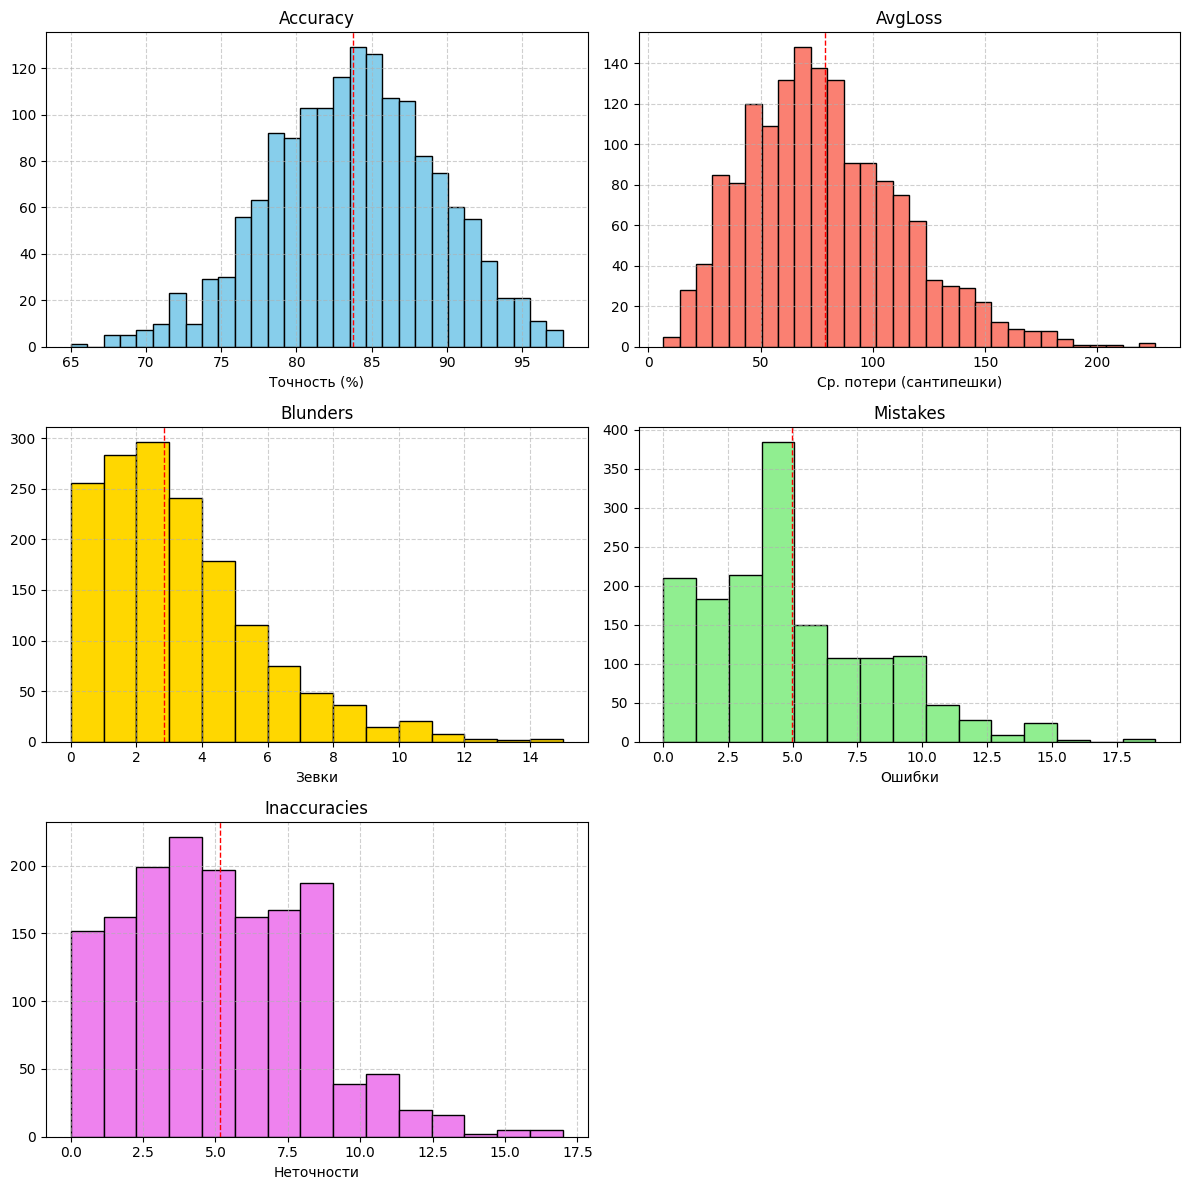

In [32]:
plot_all_metrics(players_stats=players_stats)

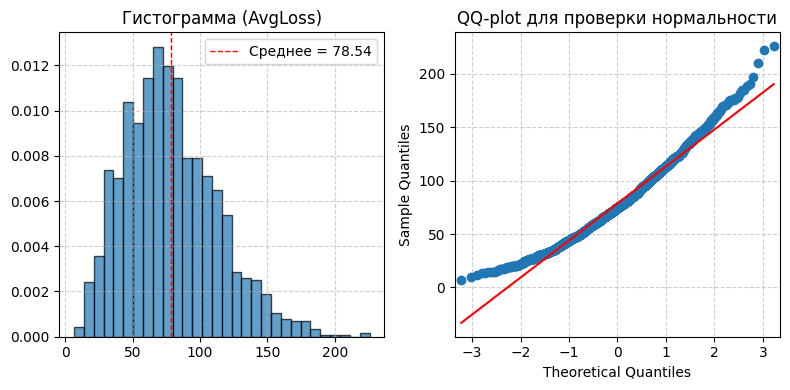

Выборочное среднее: 78.53664556962025
Выборочная медиана: 74.75
Выборочная мода: ModeResult(mode=np.float64(62.0), count=np.int64(8))
Выборочное среднеквадратическое отклонение: 34.65589707635472
Выборочный коэффициент асиметрии: 0.6440051759317793
Выборочный коэффициент эксцесса: 0.37575915903965473


NormaltestResult(statistic=np.float64(99.97721893713238), pvalue=np.float64(1.9508449322190666e-22))
ShapiroResult(statistic=np.float64(0.9738309775798868), pvalue=np.float64(2.320576145360511e-16))


In [33]:
normality_check(players_stats['AvgLoss'])

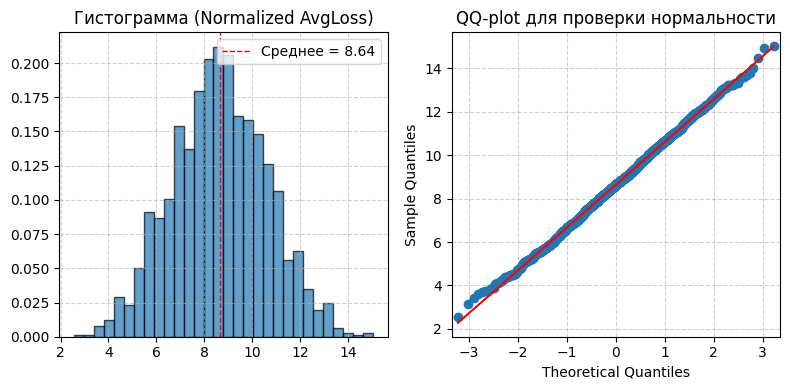

Выборочное среднее: 8.639403233474065
Выборочная медиана: 8.645807749354312
Выборочная мода: ModeResult(mode=np.float64(7.874007874011811), count=np.int64(8))
Выборочное среднеквадратическое отклонение: 1.9747976056036913
Выборочный коэффициент асиметрии: 0.035293741185015486
Выборочный коэффициент эксцесса: -0.19874537796558656


NormaltestResult(statistic=np.float64(3.3689190906045887), pvalue=np.float64(0.18554468335861538))
ShapiroResult(statistic=np.float64(0.9988720734084802), pvalue=np.float64(0.4236751533796855))


In [34]:
players_stats['Normalized AvgLoss'] = players_stats['AvgLoss'].apply(lambda x: x ** 0.5)

normality_check(players_stats['Normalized AvgLoss'])

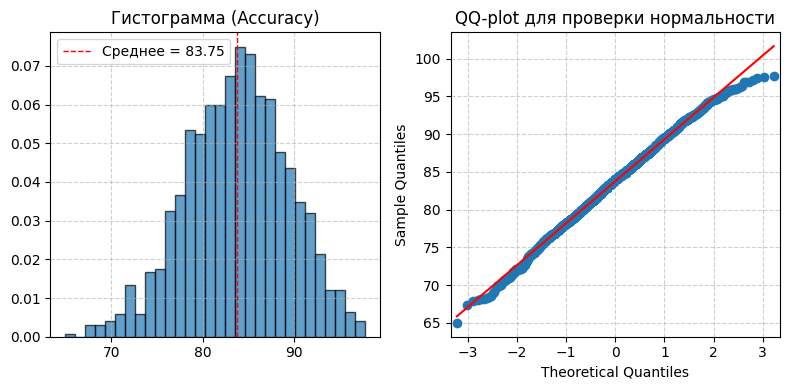

Выборочное среднее: 83.75183544303799
Выборочная медиана: 84.0
Выборочная мода: ModeResult(mode=np.float64(84.7), count=np.int64(20))
Выборочное среднеквадратическое отклонение: 5.5499986978423115
Выборочный коэффициент асиметрии: -0.14917525941063287
Выборочный коэффициент эксцесса: -0.163335042333415


NormaltestResult(statistic=np.float64(7.78027437618605), pvalue=np.float64(0.02044254137229124))
ShapiroResult(statistic=np.float64(0.9970181094520503), pvalue=np.float64(0.004098714402397896))


In [35]:
normality_check(players_stats['Accuracy'])

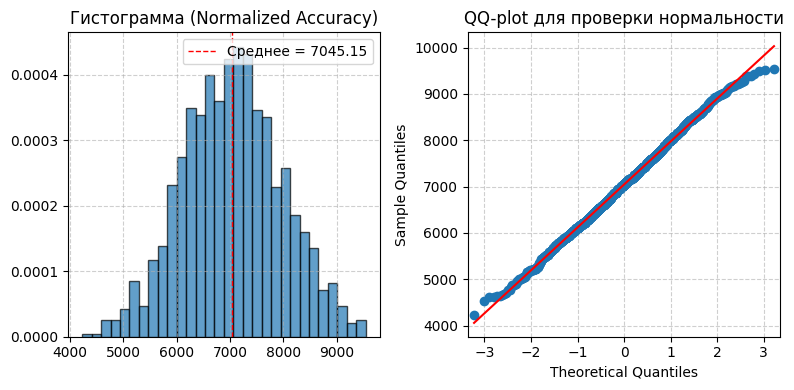

Выборочное среднее: 7045.152930379747
Выборочная медиана: 7056.0
Выборочная мода: ModeResult(mode=np.float64(7174.09), count=np.int64(20))
Выборочное среднеквадратическое отклонение: 925.9837750363024
Выборочный коэффициент асиметрии: 0.029878367293064353
Выборочный коэффициент эксцесса: -0.24597861168750468


NormaltestResult(statistic=np.float64(5.225092690620248), pvalue=np.float64(0.07334753761457219))
ShapiroResult(statistic=np.float64(0.9980477690117182), pvalue=np.float64(0.057539887778686655))


In [36]:
players_stats['Normalized Accuracy'] = players_stats['Accuracy'].apply(lambda x: x ** 2)

normality_check(players_stats['Normalized Accuracy'])

In [37]:
tournament_stats['Normalized AvgLoss'] = tournament_stats['AvgLoss'].apply(lambda x: x ** 0.5)

tournament_stats['Normalized Accuracy'] = tournament_stats['Accuracy'].apply(lambda x: x ** 2)

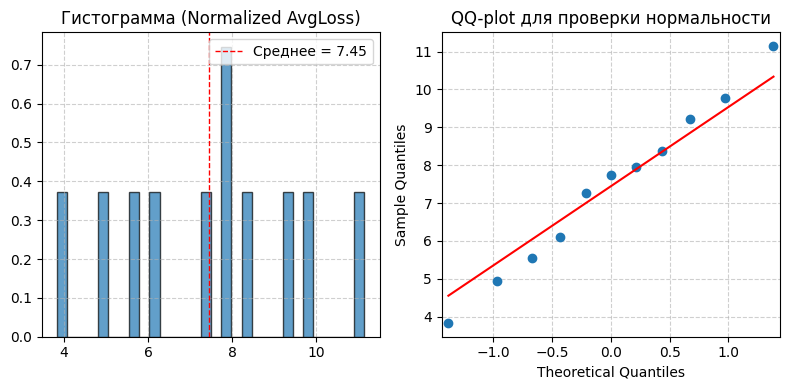

Выборочное среднее: 7.445848151519076
Выборочная медиана: 7.73950902835574
Выборочная мода: ModeResult(mode=np.float64(3.8340579025361627), count=np.int64(1))
Выборочное среднеквадратическое отклонение: 2.194374588572324
Выборочный коэффициент асиметрии: -0.024982667699188124
Выборочный коэффициент эксцесса: -0.5867786340312056


NormaltestResult(statistic=np.float64(0.1158906286047364), pvalue=np.float64(0.9437015530035247))
ShapiroResult(statistic=np.float64(0.987943245481288), pvalue=np.float64(0.9945991204184751))


/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:418: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=11 observations were given.
  return hypotest_fun_in(*args, **kwds)


In [38]:
tournament_stats['Normalized AvgLoss'] = tournament_stats['AvgLoss'].apply(lambda x: x ** 0.5)

normality_check(tournament_stats['Normalized AvgLoss'])

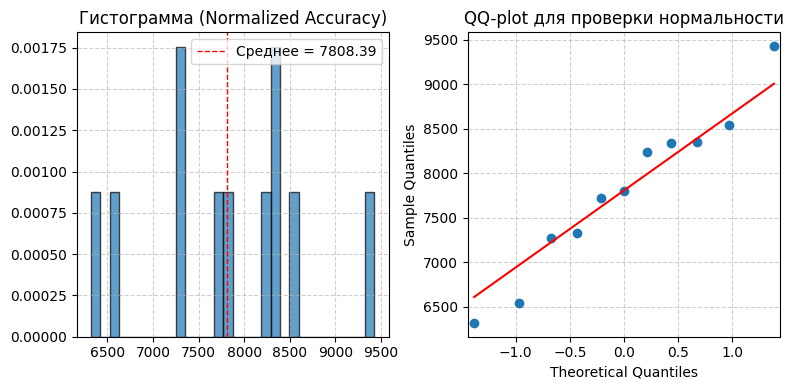

Выборочное среднее: 7808.388181818183
Выборочная медиана: 7796.889999999999
Выборочная мода: ModeResult(mode=np.float64(6320.25), count=np.int64(1))
Выборочное среднеквадратическое отклонение: 908.5831041772474
Выборочный коэффициент асиметрии: -0.08863982401029555
Выборочный коэффициент эксцесса: -0.14205572944452882


NormaltestResult(statistic=np.float64(0.02708142811905711), pvalue=np.float64(0.9865505490222706))
ShapiroResult(statistic=np.float64(0.9671166702252837), pvalue=np.float64(0.8560306141606839))


In [39]:
tournament_stats['Normalized Accuracy'] = tournament_stats['Accuracy'].apply(lambda x: x ** 2)

normality_check(tournament_stats['Normalized Accuracy'])

In [44]:
check_dispersion_equality(players_stats, tournament_stats)

Дисперсии точности в рассматриваемых выборках равны
Дисперсии потерь сантипешек в рассматриваемых выборках равны
Дисперсии числа зевков в рассматриваемых выборках равны




(np.float64(0.9341067347407009),
 np.float64(0.6319539260520439),
 np.float64(0.700065454504176))

In [47]:
detecting_cheaters(players_stats, tournament_stats)

Дисперсии точности в рассматриваемых выборках равны
Дисперсии потерь сантипешек в рассматриваемых выборках равны
Дисперсии числа зевков в рассматриваемых выборках равны


Проверка, равна ли точность в рассматриваемых партиях общей: p-value = 0.0039
Точность в рассмотренных партиях аномально высокая


Проверка, равны ли средние потери сантипешек в рассматриваемых партиях общим: p-value = 0.0372
Средние потери сантипшек в рассмотренных партиях аномально низкие


Проверка, равна ли частота зевков в рассматриваемых партиях общией : p-value = 0.1978
Число зевков в рассмотренных партиях не являются аномально низкими


In [48]:
detecting_cheaters_if_distributions_are_not_normal(players_stats, tournament_stats)

Точность в рассматриваемых партиях равна общей: p-value = 0.0050
Точность в рассмотренных партиях аномально высокая


Средние потери сантипешек в рассматриваемых партиях равны общим: p-value = 0.0398
Средние потери сантипшек в рассмотренных партиях аномально низкие


Частота зевков в рассматриваемых партиях равна общией : p-value = 0.1978
Число зевков в рассмотренных партиях не являются аномально низкими


In [42]:
players_stats.to_csv('players_stats.csv')
tournament_stats.to_csv('tournament_stats.csv')